In [1]:
!pip install -q langchain openai pinecone-client tiktoken tokenizer tqdm uuid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.1/179.1 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 87.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.0/90.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.7/283.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 15.3 MB/s eta 0:00:

In [22]:
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.vectorstores import Pinecone
import pinecone 
import os
from langchain.document_loaders import CSVLoader
import pandas as pd
import numpy as np
import tiktoken
import openai
from tqdm.auto import tqdm
from time import sleep
from uuid import uuid4
from langchain.chains.qa_with_sources import load_qa_with_sources_chain
from langchain.llms import OpenAI
import tokenizer


In [45]:
os.environ["OPENAI_API_KEY"] = "XXXXXXX"
os.environ['PINECONE_API_KEY'] = "XXXXXXX"
os.environ['PINECONE_ENV'] = "XXXXXXX"
os.environ['PINECONE_INDEX_NAME']= "XXXXXXX"

In [8]:
pinecone.init(
    api_key=os.environ['PINECONE_API_KEY'],  
    environment=os.environ['PINECONE_ENV']
)
index = pinecone.Index("homedepot")

In [58]:
df = pd.read_csv('/content/homedepotdata.csv')

In [59]:
df['avg_rating'] = df['avg_rating'].fillna('No Rating')
df = df.dropna()
df

,url,name,description,brand,price,in_stock,currency,color,avg_rating,overview
2,https://www.homedepot.com/p/Quoizel-Queenship-...,Queenship 2-Light Polished Nickel Wall Sconce,The Queenship is absolutely dripping with glam...,Quoizel,232.49,True,USD,Polished Nickel,No Rating,Durable steel construction is built to last an...
4,https://www.homedepot.com/p/Safavieh-Kilim-Rus...,Kilim Rust 5 ft. x 8 ft. Area Rug,Flat-weaving traditions of nomads from the Mid...,Safavieh,156.33,True,USD,Red,No Rating,"100% Wool, No backing, rug pad (sold separatel..."
5,https://www.homedepot.com/p/Unique-Loom-Salzbu...,Salzburg Itzling Light Blue 4' 0 x 4' 0 Square...,"Soft, muted colors like blue, gray and cream. ...",Unique Loom,34.69,False,USD,Blue,4.2,"Pile material is Polypropylene, Action back re..."
6,https://www.homedepot.com/p/Unique-Loom-Outdoo...,Outdoor Leaf Teal 6 ft. x 9 ft. Area Rug,Outdoor area rugs are the perfect way to show ...,Unique Loom,111.15,True,USD,Blue,4.6667,"100% Polypropylene, Action Back requiring use ..."
7,https://www.homedepot.com/p/Noble-House-Kaffe-...,Kaffe Coral Solid Polyester 18 in. x 18 in. Th...,These plush pillows are a great way to add som...,Noble House,26.98,True,USD,Coral,No Rating,"Includes: 1-pillow, Fabric composition: 100% p..."
...,...,...,...,...,...,...,...,...,...,...
10831,https://www.homedepot.com/p/Glidden-Speed-Wall...,Speed-Wall 1 gal. PPG1105-3 Carmelized Pears F...,Glidden Speed-Wall professional interior paint...,Glidden,12.98,False,USD,Yellow / Gold,No Rating,Built for increased productivity on high-volum...
10832,https://www.homedepot.com/p/Toledo-Fine-Locks-...,Antique Bronze Privacy Bed/Bath Door Lever Set,Toledo Fine Locks presents to our customers su...,Toledo Fine Locks,23.13,True,USD,Bronze,4.8333,"Anti-bumping cylinder, Fits doors from 1-3/8 i..."
10833,https://www.homedepot.com/p/The-Stupell-Home-D...,"30 in. x 40 in. "" Fridge Lights are for Midnig...",Our stretched canvas is created with only the ...,The Stupell Home Decor Collection,68.80,True,USD,Multi-Colored,No Rating,"Dimensions: 16 x 1.5 x 20 in., Our stretched c..."
10834,https://www.homedepot.com/p/BEHR-MARQUEE-1-gal...,1 gal. #490B-5 Cozumel Satin Enamel Exterior P...,For the ultimate in durability and beauty on v...,BEHR MARQUEE,49.98,True,USD,Turquoise / Aqua,4.853,"Satin finish offers a soft, pearl-like appeara..."


In [60]:
df["text"] = df['name'] + " " + df["brand"] + " " + df["description"] + "; Price in USD:" + df["price"].astype(str) + "; " + df["overview"] + "; Rating: " + df["avg_rating"].astype(str) + "; " + df["url"] 
df = df.drop(labels = ["description", "overview", "brand", "price", "in_stock", "currency", "color", "avg_rating"], axis = 1)

In [61]:
df

,url,name,text
2,https://www.homedepot.com/p/Quoizel-Queenship-...,Queenship 2-Light Polished Nickel Wall Sconce,Queenship 2-Light Polished Nickel Wall Sconce ...
4,https://www.homedepot.com/p/Safavieh-Kilim-Rus...,Kilim Rust 5 ft. x 8 ft. Area Rug,Kilim Rust 5 ft. x 8 ft. Area Rug Safavieh Fla...
5,https://www.homedepot.com/p/Unique-Loom-Salzbu...,Salzburg Itzling Light Blue 4' 0 x 4' 0 Square...,Salzburg Itzling Light Blue 4' 0 x 4' 0 Square...
6,https://www.homedepot.com/p/Unique-Loom-Outdoo...,Outdoor Leaf Teal 6 ft. x 9 ft. Area Rug,Outdoor Leaf Teal 6 ft. x 9 ft. Area Rug Uniqu...
7,https://www.homedepot.com/p/Noble-House-Kaffe-...,Kaffe Coral Solid Polyester 18 in. x 18 in. Th...,Kaffe Coral Solid Polyester 18 in. x 18 in. Th...
...,...,...,...
10831,https://www.homedepot.com/p/Glidden-Speed-Wall...,Speed-Wall 1 gal. PPG1105-3 Carmelized Pears F...,Speed-Wall 1 gal. PPG1105-3 Carmelized Pears F...
10832,https://www.homedepot.com/p/Toledo-Fine-Locks-...,Antique Bronze Privacy Bed/Bath Door Lever Set,Antique Bronze Privacy Bed/Bath Door Lever Set...
10833,https://www.homedepot.com/p/The-Stupell-Home-D...,"30 in. x 40 in. "" Fridge Lights are for Midnig...","30 in. x 40 in. "" Fridge Lights are for Midnig..."
10834,https://www.homedepot.com/p/BEHR-MARQUEE-1-gal...,1 gal. #490B-5 Cozumel Satin Enamel Exterior P...,1 gal. #490B-5 Cozumel Satin Enamel Exterior P...


<Axes: >

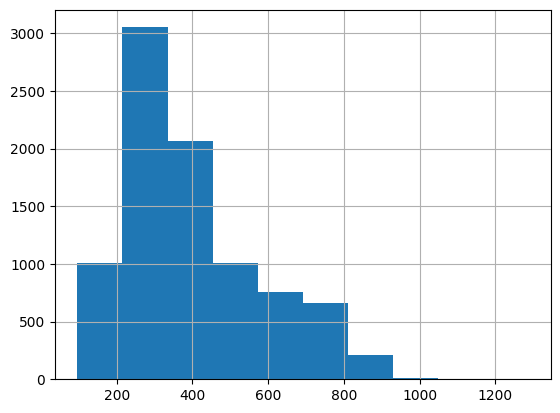

In [62]:
# Visualize the distribution of the number of tokens per row using a histogram
tokenizer = tiktoken.get_encoding("cl100k_base")
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

In [63]:
#Since all of the rows have tokens well below the 8192 limit, we can proceed as normal
df = df.drop(labels = ["n_tokens"], axis =1)

In [43]:
#adding id for the vector database
df['id'] = [str(uuid4()) for _ in range(len(df))]

In [47]:
embed_model = "text-embedding-ada-002"
batch_size = 100
openai.api_key = os.environ["OPENAI_API_KEY"]
chunks = df.to_dict(orient='records')
for i in tqdm(range(0, len(chunks), batch_size)):
    # find end of batch
    i_end = min(len(chunks), i+batch_size)
    meta_batch = chunks[i:i_end]
    # get ids
    ids_batch = [x['id'] for x in meta_batch]
    # get texts to encode
    texts = [x['text'] for x in meta_batch]
    # create embeddings and try-except added to avoid RateLimitError from both OpenAI and Pinecone Vector DB
    try:
        res = openai.Embedding.create(input=texts, engine=embed_model)
    except:
        done = False
        while not done:
            sleep(5)
            try:
                res = openai.Embedding.create(input=texts, engine=embed_model)
                done = True
            except:
                pass
    embeds = [record['embedding'] for record in res['data']]
    # cleanup metadata
    meta_batch = [{
        'text': x['text'],
        'name': x['name'],
        'url': x['url']
    } for x in meta_batch]
    to_upsert = list(zip(ids_batch, embeds, meta_batch))
    # upsert to Pinecone
    index.upsert(vectors=to_upsert)

  0%|          | 0/36 [00:00<?, ?it/s]

In [53]:
#testing functions before moving them to Slackbot server
#embedding user query
embed_model = "text-embedding-ada-002"
query = "Could you give me an overview of the Kilim Rust Area rug?"
res = openai.Embedding.create(
    input=[query],
    engine=embed_model
)
# retrieve from Pinecone
xq = res['data'][0]['embedding']

# get relevant information
res = index.query(xq, top_k=5, include_metadata=True)

In [54]:
res

{'matches': [{'id': 'f82ad27b-99e6-48e8-a53e-acbe62a6134c',
              'metadata': {'name': 'Kilim Rust 5 ft. x 8 ft. Area Rug',
                           'text': 'Kilim Rust 5 ft. x 8 ft. Area Rug Safavieh '
                                   'Flat-weaving traditions of nomads from the '
                                   'Middle East to Central Asia are revived in '
                                   'an array of contemporary but '
                                   "tribal-inspired designs in Safavieh's "
                                   'Kilim collection. Each rug is woven by '
                                   'hand of pure wool to create a unique and '
                                   'casual work of art. This is a great '
                                   'addition to your home whether in the '
                                   'country side or busy city.; Price in '
                                   'USD:156.33; 100% Wool, No backing, rug pad '
                     

In [55]:
#creating relevant background information for question
contexts = [item['metadata']['text'] for item in res['matches']]
augmented_query = "\n\n---\n\n".join(contexts)+"\n\n-----\n\n" + query

In [ ]:
# system message to 'prime' the model
primer = f"""You are Q&A bot. A highly intelligent system that answers
user questions. After these instructions, the user question will be there right below. Answer the question 
based on information from Home Depot provided to you below the user question. If the information can not be found in the information
provided by the user you truthfully say "I don't know". Refrain from saying "based on the
information".
"""

#generating response from model
res = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    messages=[
        {"role": "system", "content": primer},
        {"role": "user", "content": augmented_query}
    ]
)

In [ ]:
from IPython.display import Markdown
display(Markdown(res['choices'][0]['message']['content']))